이름: 김수현

학번: 20183911



# Part 1: Saving and Loading Models

* 이번 실습에서는 model을 저장하고 불러오는 방법에 대해서 학습니다
* 저장과 불러오기를 학습하는 것이 중요한 이유는, 많은 경우 사전에 training이 완료된 모델을 불러와서 사용할 수있어야 하기 때문입니다



In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

In [4]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
    
device

'cuda'

In [5]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 12434190.00it/s]


Extracting F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to F_MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 210310.90it/s]


Extracting F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to F_MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3928215.72it/s]


Extracting F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to F_MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6647868.53it/s]

Extracting F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to F_MNIST_data/FashionMNIST/raw



* 이미지 한개 샘플을 살펴봅니다 (이미 익숙한 그림입니다)

# Train a network

To make things more concise here, I moved the model architecture and training code from the last part to a file called `fc_model`. Importing this, we can easily create a fully-connected network with `fc_model.Network`, and train the network using `fc_model.train`. I'll use this model (once it's trained) to demonstrate how we can save and load models.

In [6]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x
    ###############

In [7]:
# Create the network, define the criterion and optimizer

model = Classifier()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)


In [27]:
epochs = 5

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        running_loss += loss.item()
    
    print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 0.5178344311522268
Training loss: 0.3899753793819881
Training loss: 0.3336285886718139
Training loss: 0.3157850740147806


## Saving and loading networks

* *저장하기*가 유용한 이유는 생각해보실 수 있죠? 우리가 training이 된 네트워크를 통해서 예측을 하고자 하는데, 매번 training을 할 수도, 이유도 없죠
* 대신에 training이 완료된 모델을 저장하고, 활용하고자 할때 불러와서 사용하면 유용하겠죠?
* Pytorch에서 우리가 training을 통해서 얻은 parameter들은 `state_dict`라는 형태로 자장됩니다
  * 즉 네트워크의 weight와 bias들이 각 layer 별로 저장됩니다. 아래 확인해보죠


In [8]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
) 

The state dict keys: 

 odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])


In [9]:
print("Our optimizer: \n\n", optimizer, '\n')
print("The state dict keys: \n\n", optimizer.state_dict().keys())   # 이어서 학습할 경우 optimizer저장해야함

Our optimizer: 

 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.003
    maximize: False
    weight_decay: 0
) 

The state dict keys: 

 dict_keys(['state', 'param_groups'])


* 위 state dictionary를 `torch.save`를 사용하여 저장하면 됩니다
* 예를 들어서 이름을 `checkpoint.pth`로 저장하도록 해보죠


In [10]:
torch.save(model.state_dict(), 'model_statedict.pth')   # 저장하기

* 위 저장된 state dict를 다시  `torch.load`를 통해서 불러올 수 있습니다

In [11]:
state_dict = torch.load('model_statedict.pth')   # 불러오기
print(state_dict.keys())

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])


* 저장된 state dict를 모델이 적용하기 위해서는 다음과 같은 명령어를 사용합니다"
  * `model.load_state_dict(state_dict)`.

In [32]:
model.load_state_dict(state_dict)   # 모델에 적용

<All keys matched successfully>

In [33]:
torch.save(optimizer.state_dict(), 'opt_statedict.pth')

In [34]:
opt_state_dict = torch.load('opt_statedict.pth')

In [35]:
optimizer.load_state_dict(opt_state_dict)

## Dictionary로 저장하기

In [12]:
checkpoint = {'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

In [37]:
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

* 한가지 주의해야할 부분이 있습니다. 쉽게 생각해볼 수 있는데, 내가 저장된 state_dict를 적용하고자 하는 모델 구조를 항상 있어야 합니다


In [38]:
torch.save(model, 'model_save.pt')

In [39]:
model_load = torch.load('model_save.pt')

# Part 2: Transfer Learning

* Part 2에서는 이미 training이 잘된 네트워크를 불러와서 적용하는 방법을 실습하도록 하겠습니다
* '잘된 네트워크'는 여기서 [ImageNet](http://www.image-net.org/) [available from torchvision](http://pytorch.org/docs/0.3.0/torchvision/models.html)에서 학습된 모델을 활용하도록 하겠습니다
* `ImageNet`은 14,000,000개의 image파일을 20,000개의 class로 분류되어있는 database 운영
  * 예를 들면 `딸기`, `풍선`등의 분류가 있으면, 각 분류별로 수백개의 image가 존재합니다
  * 각 이미지들은 수작업으로 labeling 되어있고, bounding box까지 표시가 되어 있습니다
  * 2010년 이후로 대회를 진행 ImageNet Large Scale Visual Recognition Challenge (ILSVRC)
    * 수천개의 class를 추려서 대회 진행
  * AlexNet과 그 이후: top-5 분류에서 15.3%로 혁신적 결과를 시작으로 deep learning 시대를 견인
    * GPU의 사용!
* 우리는 실제 사용하고자 하는 network를 직접 training 하는 경우보다, imagenet 등에서 매우 잘 동작하는 network을 적용하여, 부분적 학습을 통해서 사용하게 됩니다
* 본 실습에서는 imagenet에서 모델을 받아서 적용하는 방법을 알아보죠~


### Data 준비
* 위 Imagenet에서 사용된 자료는 다양한 class를 분류하는 작업을 수행합니다
* 이를 우리가 지난 시간에 받았던 `dog`, `cat`분류 문제에 적용하는 방법을 알아보도록 하겠습니다
* dataset은 다음 url에서 download 혹은 `+Add data`를 통해서 가져옵니다

https://www.kaggle.com/datasets/dlsunghlim/hallym-deep-learning-dogcat-data

### Loading Densenet121
* 본 실습을 위해서 우리는 [DenseNet](http://pytorch.org/docs/0.3.0/torchvision/models.html#id5)을 활용하고자 합니다. 아래 불러오기와 구조를 살펴보죠

In [13]:
from torchvision import models
model = models.densenet121(pretrained=True)
model

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 211MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

### densenet121의 구조

* 위에서 불러온 `densenet121`의 구조를 살펴보면 크게 두가지로 나눠집니다
  * (features) 부분과
  * (classifier) 부분으로 나눠집니다
* 위에서 (features) 부분은 매우 복잡한 layer들로 구성되어 있으며, 특별히, convolutional network으로 구성되어 있습니다. (이부분은 다음 시간부터 배우게 됩니다)
* 여기서 (features)에 해당하는 부분은 그대로 활용할 것이며, classifier에 대당하는 부분만 바꿔서 사용하고자 합니다
* 여기서 유념해야하는 부분은 classifier의 `output_feature=1000` 부분입니다
  * (classifier)는 fully-connected layer로
    * `(classifier): Linear(in_features=1024, out_features=1000)` 임
  * `output_feature=1000`는 분류는 1000가지로 수행하고 있는 네트워크라는 뜻입니다
  * 우리는 이부분을 2가지 dog, cat 중 한가지로 수행하도록 변경하고자 합니다
  
* 또한, densenet121은 입력 image가 224x224로 받습니다
* Densenet121에서 정규화한 값 또한 맞춰줘야 합니다 Densenet121의 경우는 
  * mean `[0.485, 0.456, 0.406]` and the standard deviations `[0.229, 0.224, 0.225]로 학습되었습니다
* 위 정보에 맞춰서 우리 학습하고자 하는 IMAGE를 불러옵니다

In [15]:
data_dir = '../input/hallym-deep-learning-dogcat-data'

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir +'/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

## Transfer learning

* 위에서 가져온 densenet121의 네트워크에서 우리는 `classifier` 부분을 다시 우리 목적에 맞게 설계하고 다시 학습하고자 합니다 (이유는 영상에서 설명하도록 하겠습니다)

* 이때, densenet121에서 `feature` 부분은 다시 training 하지 않고 그대로 유지합니다. 이를 위해서 `feature`부분은 동결 (freeze)하고, 즉 backprop을 수행하지 않고, `classifier`부분만 수행합니다.

* 동결을 위해서 모든 `model.paramters()`의 `requires_grad = False` 로 바꿔줍니다
* 이후 classifier 부분을 덮어서 새로 구현하면, 이부분은 자동으로 gradient가 활성화 된 상태로 만들어지겠죠?

In [42]:
from collections import OrderedDict

In [43]:
# Backprop을 수행하지 않도록 parameter들을 동결시킴
for param in model.parameters():
    param.requires_grad = False

classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 2))                          
                          ]))
    
model.classifier = classifier  # 새로 생성한 레이어는 학습이 되지 않은 랜덤한 값이 들어감 -> 재학습 해야함

## Retraining the network

In [44]:
model = models.densenet121(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 2)
                                 )

criterion = nn.CrossEntropyLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [45]:
epochs = 3

for epoch in range(epochs):
    running_loss = 0
    for inputs, labels in trainloader:
        
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logits = model.forward(inputs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        
    test_loss = 0
    accuracy = 0
       
    model.eval()    
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            logits = model.forward(inputs)
            batch_loss = criterion(logits, labels)

            test_loss += batch_loss.item()

            # Calculate accuracy
            ps = F.softmax(logits, dim=1)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    model.train()
    

    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {running_loss/len(testloader):.3f}.. "
          f"Test loss: {test_loss/len(testloader):.3f}.. "
          f"Test accuracy: {accuracy/len(testloader):.3f}")
            
            
########################################################

Epoch 1/3.. Train loss: 1.522.. Test loss: 0.041.. Test accuracy: 0.984
Epoch 3/3.. Train loss: 1.335.. Test loss: 0.038.. Test accuracy: 0.983


## Problem 1
pytorch 에서 `VGG16` network을 받아서 3 epoch 동안 transfer learning 수행

1) Training set을 training set과 validation set으로 나눠서 dataloader 준비 할 것

2) epoch 별 traning loss, validation loss 그래프를 출력

3) 최종 test accuracy를 출력하세요

In [22]:
model = models.vgg16(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 67.7MB/s] 


In [23]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [25]:
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

In [35]:
train_data = datasets.ImageFolder(data_dir +'/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

valid_size = 0.2

num_train = int(len(train_data))
indices = list(range(num_train))    
np.random.shuffle(indices)  

split = int(np.floor(valid_size * num_train))   
train_idx, valid_idx = indices[split:], indices[:split]    

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)



train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=64, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [36]:
for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(nn.Linear(25088, 5000),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(5000, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(256, 2)
                                 )

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [39]:
epoch = 3

train_loss = torch.zeros(epoch)
valid_loss = torch.zeros(epoch)

for e in range(epoch):

    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        logits = model(inputs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        train_loss[e] += loss.item()
    
    train_loss[e] /= len(train_loader)
        
        
    model.eval()
    with torch.no_grad(): 
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            logits = model(inputs)
            loss = criterion(logits, labels)
            valid_loss[e] += loss.item()

    valid_loss[e] /= len(valid_loader)

    test_loss = 0
    accuracy = 0
         
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            logits = model.forward(inputs)
            batch_loss = criterion(logits, labels)

            test_loss += batch_loss.item()

            ps = F.softmax(logits, dim=1)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    model.train()


    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTest Loss: {:.6f} \tTest accuracy: {:.6f}'.format(
        e+1, train_loss[e], valid_loss[e], test_loss, accuracy))
    
########################################################

Epoch: 1 	Training Loss: 0.193199 	Validation Loss: 0.185838 	Test Loss: 1.903012 	Test accuracy: 39.328125
Epoch: 2 	Training Loss: 0.210643 	Validation Loss: 0.264786 	Test Loss: 3.012246 	Test accuracy: 39.093750
Epoch: 3 	Training Loss: 0.283517 	Validation Loss: 0.347445 	Test Loss: 4.122564 	Test accuracy: 39.156250


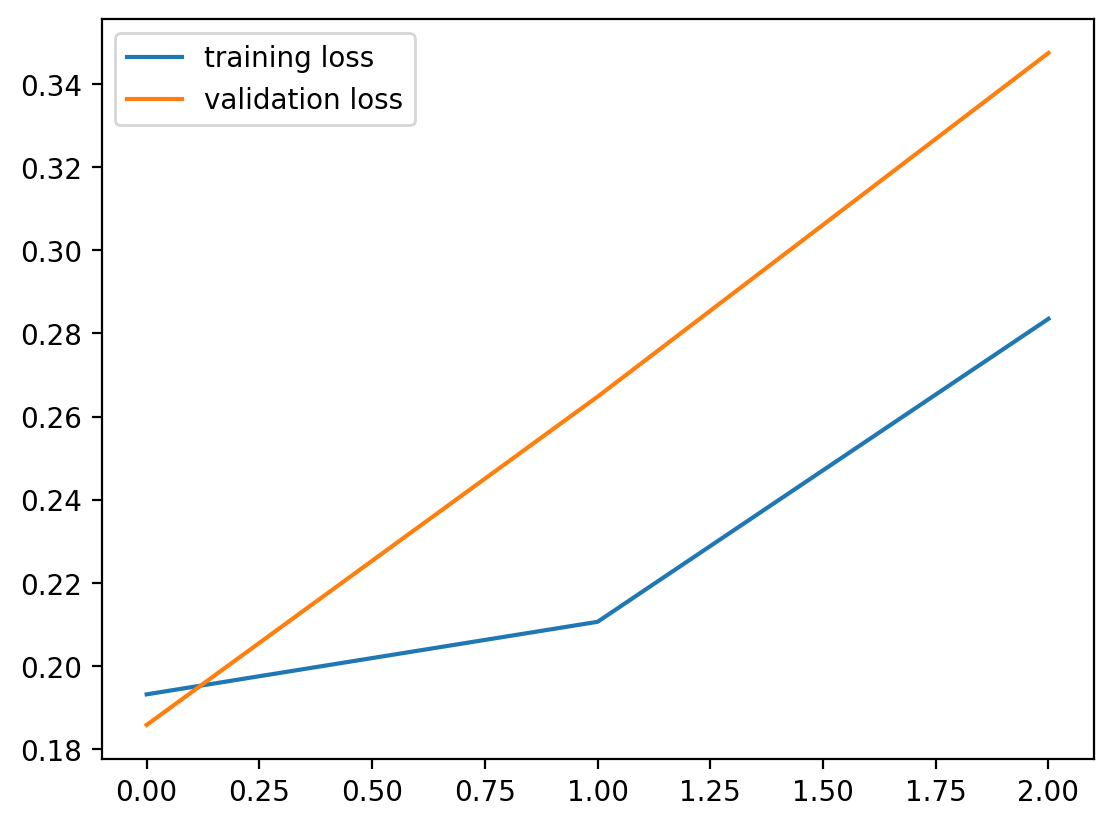

In [40]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label = 'training loss')
plt.plot(valid_loss, label = 'validation loss')
plt.legend()